# Simulate impedance data from equivalent circuit models

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
import os
from impedance.models.circuits import CustomCircuit
import pandas as pd

if '../bayes-drt' not in sys.path:
    sys.path.append('../bayes-drt')
import eis_utils as gt
from stan_models import save_pickle,load_pickle

%load_ext autoreload
%autoreload 2

In [46]:
"Functions for adding artificial noise"

def add_simple_noise(Z,seed,scale,kind='proportional'):
    randstate = np.random.RandomState(seed)
    rands = randstate.normal(loc=0,size=(len(Z),2),scale=scale)
    Z = np.copy(Z)    
    if kind=='proportional':
        sigma_r = Z.real*scale
        sigma_i = Z.imag*scale
        Z += rands[:,0]*Z.real + rands[:,1]*Z.imag*1j
    elif kind=='modulus':
        mod = ((Z*Z.conjugate())**0.5).real
        Z += rands[:,0]*mod + rands[:,1]*mod*1j
        sigma_r = mod*scale
        sigma_i = mod*scale
    elif kind=='uniform':
#         mod = ((Z*Z.conjugate())**0.5).real
#         std = np.std(mod)
#         Z_range = np.max(Z.real) - np.min(Z.real)
        Z += rands[:,0] + rands[:,1]*1j
        sigma_r = scale
        sigma_i = scale
    
    return Z,sigma_r,sigma_i

def add_model_noise(Z,seed,alpha,beta,model='Orazem'):
    "Add noise following Orazem or Macdonald's models"
    randstate = np.random.RandomState(seed)
    rands = randstate.normal(loc=0,size=(len(Z),2),scale=1)    
    Z = np.copy(Z)
    if model=='Orazem':
        # real and imaginary sigmas are equal and contain contributions from real and imaginary impedance magnitudes
        sigma = alpha*np.abs(Z.real) + beta*np.abs(Z.imag)
        Z += rands[:,0]*sigma + rands[:,1]*sigma*1j
        sigma_r = sigma
        sigma_i = sigma
    elif model=='Macdonald':
        # real and imaginary sigmas are distinct and include a uniform resolution contribution and a 
        # proportional contribution
#         Zmod = (Z*Z.conjugate()).real**0.5
        sigma_r = alpha + beta*np.abs(Z.real)
        sigma_i = alpha + beta*np.abs(Z.imag)
        Z += rands[:,0]*sigma_r + rands[:,1]*sigma_i*1j
    
    return Z,sigma_r,sigma_i

def zarc_drt(t,t0,n):
    "Analytical DRT of ZARC"
    return (1/(2*np.pi))*np.sin((1-n)*np.pi)/(np.cosh(n*np.log(t/t0))-np.cos((1-n)*np.pi))

def ger_drt(t,t0):
    "Analytical DRT of Gerischer"
    t = np.sort(t)
    tl = t[t<=t0]
    th = t[t>t0]
    out = np.zeros(len(t))
    out[:len(tl)] = (1/np.pi)*np.sqrt(tl/(t0-tl))
    out[len(tl):] = 0
    return out

def hn_drt(t,t0,nu,beta):
    theta = np.arctan(np.abs(np.sin(nu*np.pi)/((t/t0)**nu + np.cos(nu*np.pi))))
    g = (1/np.pi)*(t/t0)**(nu*beta)*np.sin(beta*theta)/((t/t0)**(2*nu) + 2*(t/t0)**nu*np.cos(nu*np.pi) + 1)**(beta/2)
    return g

def drt_from_ecm(params,tau,num_RC=None):
    """Get analytical DRT from equivalent circuit model parameters
    ECM must be a series of ZARCS with R_infty and inductance
    """
    if num_RC is None:
        num_RC = int((len(params) - 2)/3)
    gamma = np.zeros_like(tau)
    for n in range(num_RC):
#         print(n)
        R = params[f'R{n}']
        Q = params[f'Q{n}']
        n = params[f'n{n}']
#         print(R,Q,n)
        tau_0 = (R*Q)**(1/n)
#         print(tau_0)
        gamma += R*zarc_drt(tau,tau_0,n)
    return gamma


# Synthetic spectra

In [29]:
freq = np.logspace(6,-2,81)
tau = 1/(2*np.pi*freq)
# finer tau for plotting
tau_plot = np.logspace(-7,2,200)
sim_path = '../data/simulated'

In [14]:
1/np.diff(np.log(freq))

array([-4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34294482,
       -4.34294482, -4.34294482, -4.34294482, -4.34294482, -4.34

In [106]:
# define circuits
circ_rc = CustomCircuit(circuit='R0-p(R1,C1)',initial_guess=[1,1,1e-2])
circ_zarc = CustomCircuit(circuit='R0-p(R1,E1)',initial_guess=[1,1,1e-3**(0.8),0.8])
circ_ger = CustomCircuit(circuit='R0-G0',initial_guess=[1,1,1e-2])
circ_2rc = CustomCircuit(circuit='R0-p(R1,C1)-p(R2,C2)',initial_guess=[1,1,1e-2,1,1e-3])
circ_2zarc = CustomCircuit(circuit='R0-p(R1,E1)-p(R2,E2)',initial_guess=[1,1,1e-2**0.8,0.8, 1,1e-3**0.8,0.8])
circ_rl = CustomCircuit(circuit='R0-p(R1,E1)-p(R2,E2)',initial_guess=[1,1,1e-2**0.8,0.8, -0.2,-10,0.9])

circuits = [circ_rc,circ_zarc,circ_ger,circ_2rc,circ_2zarc,circ_rl]
circuit_labels = ['RC','ZARC','Gerischer','2RC','2ZARC','ZARC-RL']

# define analytical DRTs
# gamma_rc is delta function
gamma_zarc = zarc_drt(tau_plot,1e-3,0.8)
gamma_ger = ger_drt(tau_plot,1e-2)
# gamma_2rc is 2 delta functions
gamma_2zarc = zarc_drt(tau_plot,1e-2,0.8) + zarc_drt(tau_plot,1e-3,0.8)
gamma_rl = zarc_drt(tau_plot,1e-2,0.8) - 0.2*zarc_drt(tau_plot,(10*0.2)**(1/0.9),0.9)

gammas = [None,gamma_zarc,gamma_ger,None,gamma_2zarc,gamma_rl]

In [32]:
1e-3**0.8

0.003981071705534972

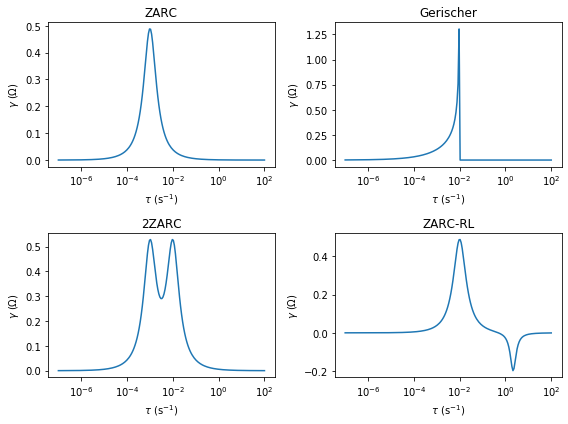

In [251]:
# plot and save DRTs
fig,axes = plt.subplots(2,2,figsize=(8,6))

i = 0
for label,gamma in zip(circuit_labels,gammas):
    if gamma is not None:
        ax = axes.ravel()[i]
        ax.plot(tau_plot,gamma)
        ax.set_title(label)
        ax.set_xscale('log')
        ax.set_xlabel(r'$\tau$ (s$^{-1}$)')
        ax.set_ylabel('$\gamma$ ($\Omega$)')
        
        df = pd.DataFrame(np.array([tau_plot, gamma]).T,columns=['tau','gamma'])
        df.to_csv(os.path.join(sim_path,'gamma_{}.csv'.format(label)),index=False)
        i += 1
        
fig.tight_layout()

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AE242B1F48>,
      dtype=object)

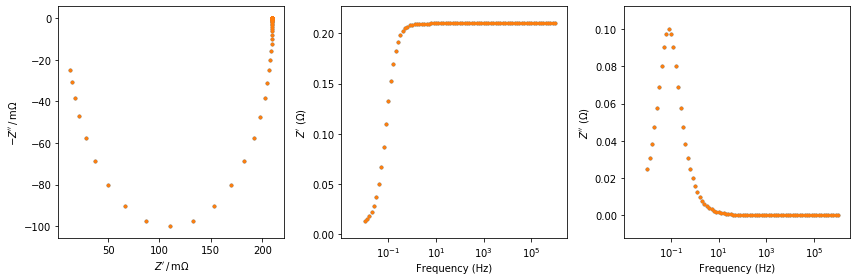

In [258]:
circ_temp = CustomCircuit(circuit='R0-p(R2,E2)',initial_guess=[0.21,-0.2,-10,1])
circ2 = CustomCircuit(circuit='R0-p(R2,L2)',initial_guess=[0.01,0.2,0.4])
Z_tmp = circ_temp.predict(freq)
Z_tmp2 = circ2.predict(freq)
df = gt.construct_eis_df(freq,Z_tmp)
df2 = gt.construct_eis_df(freq,Z_tmp2)
fig,axes = plt.subplots(1,3,figsize=(12,4))
gt.plot_full_eis(df,axes=axes,bode_cols=['Zreal','Zimag'])
gt.plot_full_eis(df2,axes=axes,bode_cols=['Zreal','Zimag'])

Simulating circuit based on initial parameters
0.0019240425371491675
0.007696170148596667
0.019240425371491655
0.002061488566536492
0.00824595426614595
0.020614885665364874
0.002116739902068842
0.008466959608275367
0.02116739902068843
Simulating circuit based on initial parameters
0.0019220705718076272
0.007688282287230483
0.01922070571807623
0.0018845575504606643
0.007538230201842673
0.018845575504606665
0.002191251602191271
0.008765006408765062
0.02191251602191267
Simulating circuit based on initial parameters
0.00193540108469462
0.007741604338778473
0.0193540108469462
0.0021982157090097917
0.00879286283603918
0.02198215709009798
0.0020574543705884846
0.008229817482353909
0.02057454370588478
Simulating circuit based on initial parameters
0.0037862695757117587
0.015145078302847042
0.037862695757117586
0.004053746041079881
0.016214984164319546
0.04053746041079886
0.0042148463797584655
0.016859385519033845
0.04214846379758461
Simulating circuit based on initial parameters
0.003897161951

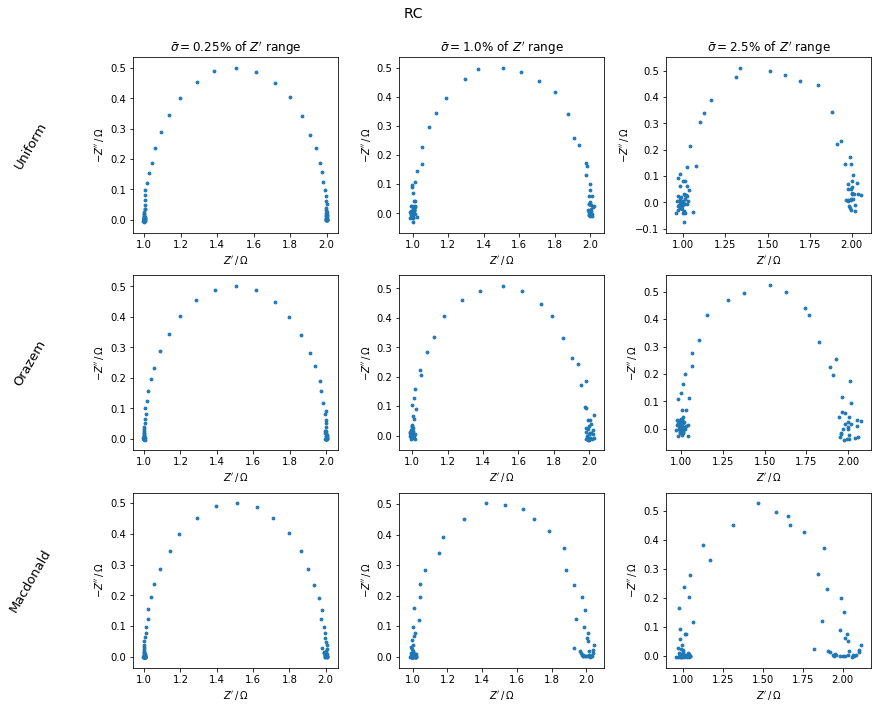

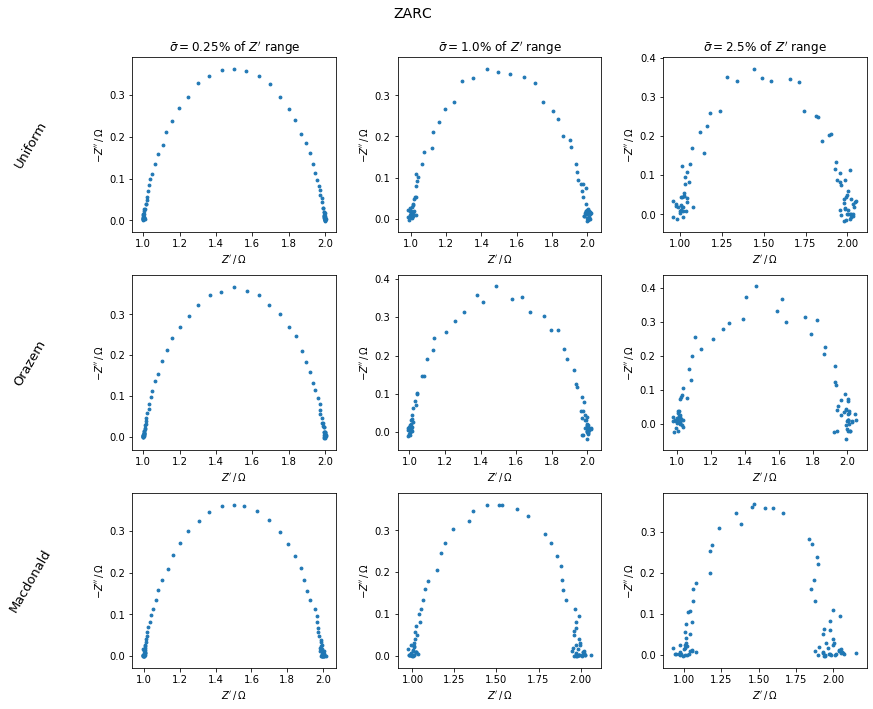

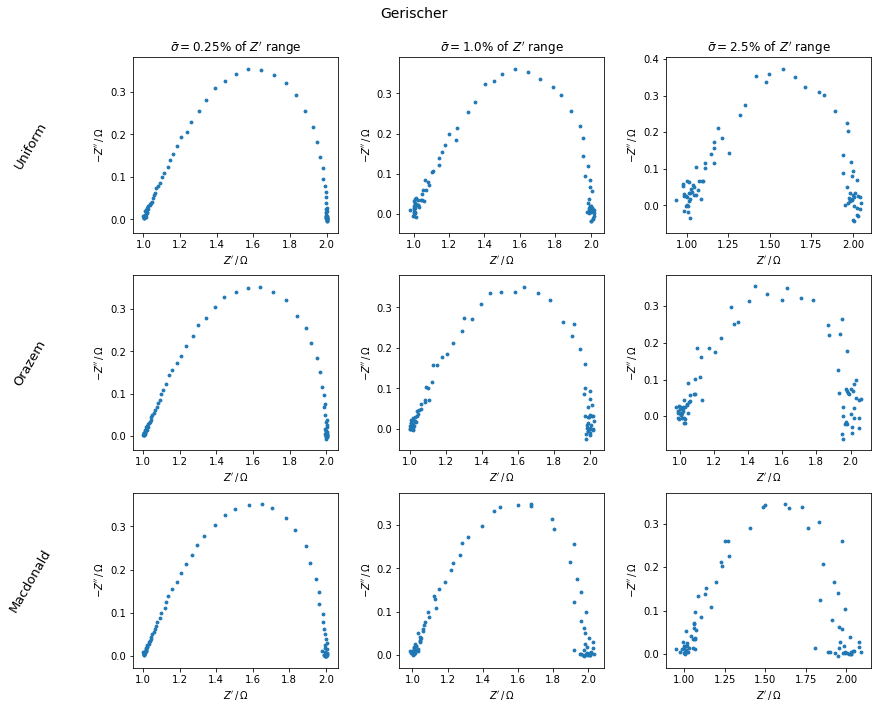

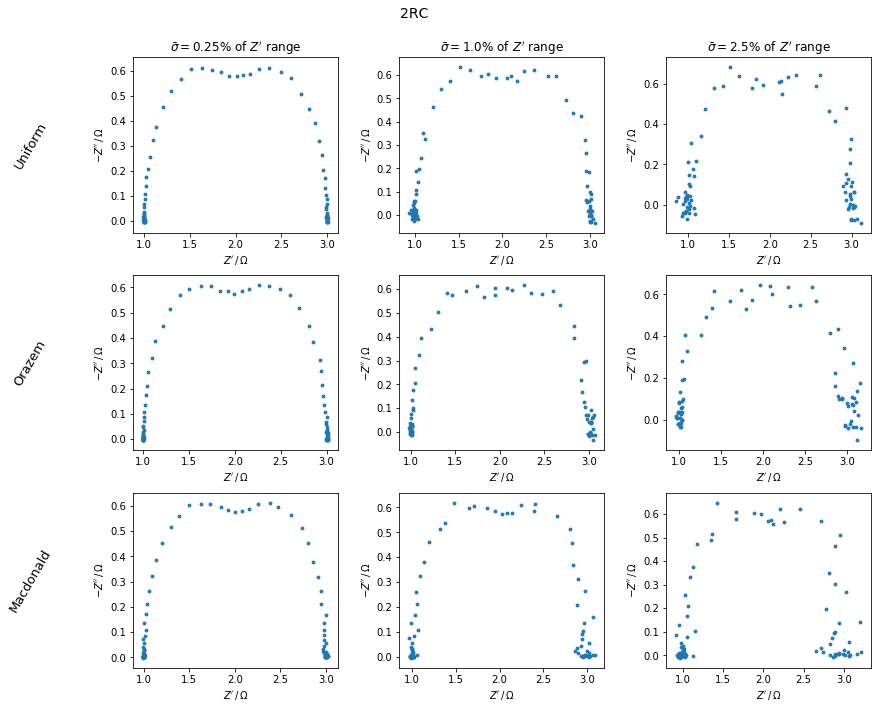

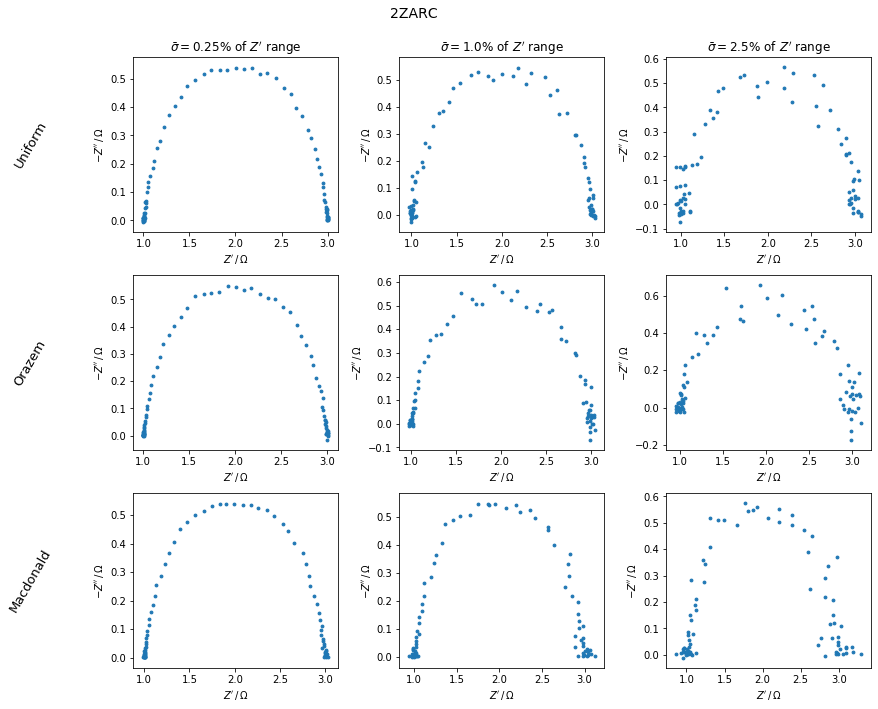

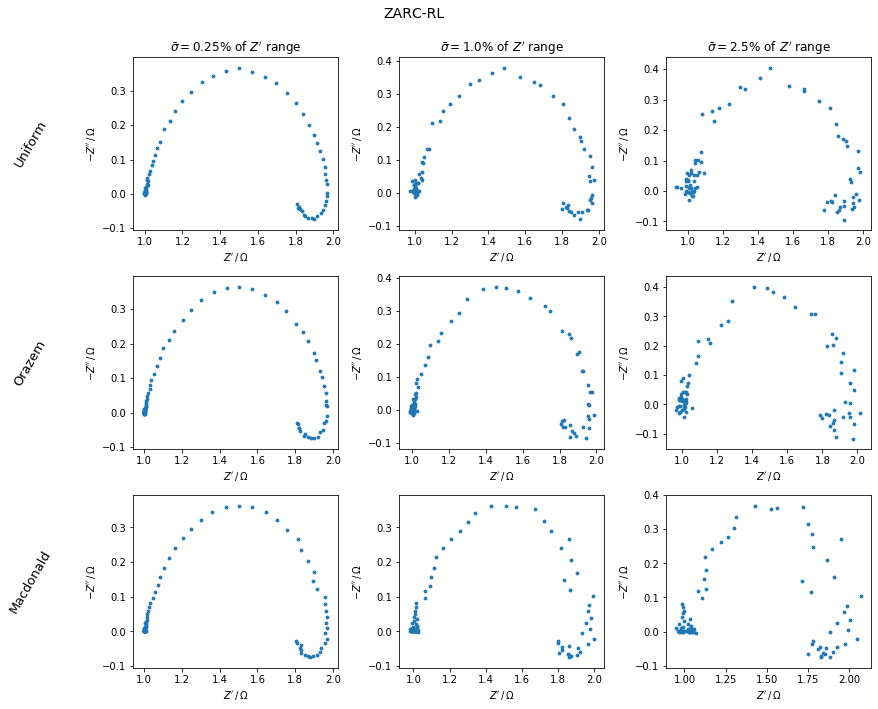

In [250]:
rng = np.random.RandomState(seed=135348)

for circuit,label in zip(circuits,circuit_labels):
    Z = circuit.predict(freq)
    Z_range = np.max(Z.real) - np.min(Z.real)
    mean_zr = np.mean(np.abs(Z.real))
    mean_zi = np.mean(np.abs(Z.imag))

    mean_sigmas = [0.0025,0.01,0.025] # as fraction of Z_range

    fig,axes = plt.subplots(3,3,figsize=(13,10))
    
    # Save noiseless data
    df = gt.construct_eis_df(freq,Z)
    df.to_csv(os.path.join(sim_path,'Z_{}_noiseless.csv'.format(label)),index=False)

    # uniform noise
    # use the same seed for each noise level, but use different seeds for different circuits and different error structures
    unif_seed = rng.randint(1e5)
    for i,mean_sigma in enumerate(mean_sigmas):
        Zn,sigma_r,sigma_i = add_simple_noise(Z,unif_seed,mean_sigma*Z_range,'uniform')
        # check average deviation
        print((np.mean(np.abs((Zn-Z).real)) + np.mean(np.abs((Zn-Z).imag)))/2)
        df = gt.construct_eis_df(freq,Zn)
        df['sigma_re'] = sigma_r
        df['sigma_im'] = sigma_i
        gt.plot_nyquist(df,ax=axes[0,i])
#         print(f'{label}_uniform_{mean_sigma}.csv')
        df.to_csv(os.path.join(sim_path,'Z_{}_uniform_{}.csv'.format(label,100*mean_sigma)),index=False)

    # Orazem model
    orazem_seed = rng.randint(1e5)
    for i,mean_sigma in enumerate(mean_sigmas):
        # set alpha_re = alpha_im
        alpha = mean_sigma*Z_range/(mean_zr+mean_zi)
        Zn,sigma_r,sigma_i = add_model_noise(Z,orazem_seed,alpha,alpha,'Orazem')
        # check average deviation
        print((np.mean(np.abs((Zn-Z).real)) + np.mean(np.abs((Zn-Z).imag)))/2)
        df = gt.construct_eis_df(freq,Zn)
        df['sigma_re'] = sigma_r
        df['sigma_im'] = sigma_i
        gt.plot_nyquist(df,ax=axes[1,i])
        df.to_csv(os.path.join(sim_path,'Z_{}_Orazem_{}.csv'.format(label,100*mean_sigma)),index=False)

    # Macdonald model
    macdonald_seed = rng.randint(1e5)
    for i,mean_sigma in enumerate(mean_sigmas):
        # set alpha = 0.1*mean_sigma, leave remainder to proportional error
        alpha = 0.1*mean_sigma*Z_range
        beta = mean_sigma*1.8*Z_range/(mean_zr+mean_zi)
        Zn,sigma_r,sigma_i = add_model_noise(Z,macdonald_seed,alpha,beta,'Macdonald')
        # check average deviation
        print((np.mean(np.abs((Zn-Z).real)) + np.mean(np.abs((Zn-Z).imag)))/2)
        df = gt.construct_eis_df(freq,Zn)
        df['sigma_re'] = sigma_r
        df['sigma_im'] = sigma_i
        gt.plot_nyquist(df,ax=axes[2,i])
        df.to_csv(os.path.join(sim_path,'Z_{}_Macdonald_{}.csv'.format(label,100*mean_sigma)),index=False)

    for ax,mean_sigma in zip(axes[0],mean_sigmas):
        ax.set_title(r'$\bar{{\sigma}}=${}% of $Z^\prime$ range'.format(100*mean_sigma))

    for ax, model in zip(axes[:,0],['Uniform','Orazem','Macdonald']):
        ax.text(-0.5,0.5,model,transform=ax.transAxes,rotation=60,size=13,ha='center',va='center')

    fig.tight_layout()
    fig.subplots_adjust(left=0.2,wspace=0.3,top=0.91)
    fig.suptitle(label,size=14)

## Truncated RL-ZARC-ZARC

Simulating circuit based on initial parameters


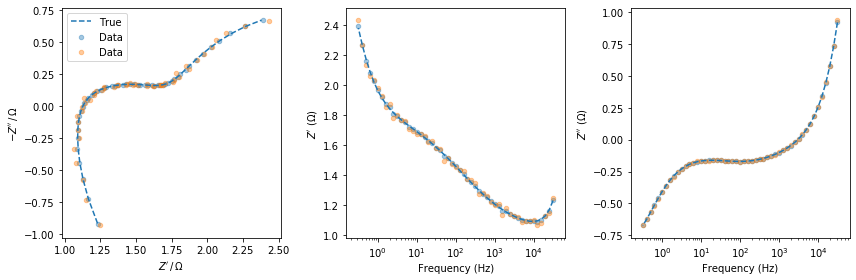

In [19]:
# define circuit
t1 = 1e-3
t2 = 1
R1 = 0.8
R2 = 2
n1 = 0.5
n2 = 0.8
Q1 = (t1**n1)/R1
Q2 = (t2**n2)/R2

tL = 1e-6
L = 5e-6
RL = L/tL

circ_2rqt = CustomCircuit(circuit='R0-p(R1,E1)-p(R2,E2)-p(R3,L3)',
                          initial_guess=[1, R1,Q1,n1, R2,Q2,n2, RL,L])

# truncated frequency range
freqt = np.logspace(4.5,-0.5,51)

# noiseless data
label = 'trunc'
Z = circ_2rqt.predict(freqt)
df = gt.construct_eis_df(freqt,Z)
fig,axes = plt.subplots(1,3,figsize=(12,4))
# plot true impedance
gt.plot_full_eis(df,axes=axes,bode_cols=['Zreal','Zimag'],plot_func='plot',label='True',ls='--')
# save noiseless data
df.to_csv(os.path.join(sim_path,'Z_{}_noiseless.csv'.format(label)),index=False)

# add noise
rng = np.random.RandomState(seed=437895)
seed = rng.randint(1e5)
err_model = 'Macdonald'
for mean_sigma in [0.0025,0.01]:
    # set noise params
    Z_range = np.max(Z.real) - np.min(Z.real)
    mean_zr = np.mean(np.abs(Z.real))
    mean_zi = np.mean(np.abs(Z.imag))
    alpha = 0.1*mean_sigma*Z_range
    beta = mean_sigma*1.8*Z_range/(mean_zr+mean_zi)
    Zn,sigma_r,sigma_i = add_model_noise(Z,seed,alpha,beta,err_model)
    ndf = gt.construct_eis_df(freqt,Zn)
    # plot noisy data
    gt.plot_full_eis(ndf,axes=axes,bode_cols=['Zreal','Zimag'],label='Data',s=20,alpha=0.4)
    # save noisy data
    ndf['sigma_re'] = sigma_r
    ndf['sigma_im'] = sigma_i
    ndf.to_csv(os.path.join(sim_path,'Z_{}_{}_{}.csv'.format(label,err_model,100*mean_sigma)),index=False)

# true DRT (except RL)
g_2rqt = R1*zarc_drt(tau_plot,t1,n1) + R2*zarc_drt(tau_plot,t2,n2)
gdf = pd.DataFrame(np.array([tau_plot, g_2rqt]).T,columns=['tau','gamma'])
gdf.to_csv(os.path.join(sim_path,'gamma_{}.csv'.format(label)),index=False)

In [33]:
Q1

0.039528470752104736

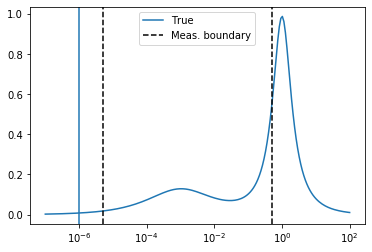

In [313]:
# plot true DRT
fig,ax = plt.subplots()
ax.plot(tau_plot,g_2rqt,label='True')
ax.axvline(tL)
ax.set_xscale('log')

ax.axvline(1/(2*np.pi*np.min(freqt)),ls='--',c='k',label='Meas. boundary')
ax.axvline(1/(2*np.pi*np.max(freqt)),ls='--',c='k')

ax.legend()

In [11]:
freqt

NameError: name 'freqt' is not defined

In [262]:
freqt1 = np.logspace(6,-2,81)
circ = '2RC'
err_model = 'Macdonald'
noise_level = 1.0

base_file = os.path.join(sim_path,'Z_{}_{}_{}.csv'.format(circ,err_model,noise_level))
base_df = pd.read_csv(base_file)

# Experimental data
## LIB data from DRTtools

There were several sample data files included in a folder named `import file samples` in a previous release of DRTtools. The current version available on Github (https://github.com/ciuccislab/DRTtools) does not appear to include these files. The file we selected was collected from a commercial lithium-ion battery.

In [139]:
# load LIB data
file = '../data/experimental/DRTtools_LIB_data.txt'
lib_df = pd.read_csv(file,sep='\t',header=None)
lib_df = pd.DataFrame(lib_df.values,columns=['Freq','Zreal','Zimag'])
Z_lib = (lib_df['Zreal'] + 1j*lib_df['Zimag']).values

# generate file with 1/4 of points (5 ppd)
f_qtr = lib_df['Freq'].values[::4]
Z_qtr = Z_lib[::4]
qtr_df = gt.construct_eis_df(f_qtr,Z_qtr)
qtr_df.to_csv('../data/experimental/DRTtools_LIB_data_qtr.csv',index=False)

Initial parameters: {'HFR': 0.11330933688784015, 'Lstray': 1e-06, 'R0': 0.1, 'Q0': 0.001, 'n0': 0.5}
Initial peak frequencies: [15915494.309189534]
1 RC element(s): Best result 0.00043 achieved within 4 restarts
New RQ element: peak frequency 6.30e-03, params {'R1': 0.041995882671944984, 'Q1': 228.42562995644008, 'n1': 0.7}
2 RC element(s): Best result 0.000103 achieved within 5 restarts
New RQ element: peak frequency 4.47e+02, params {'R2': 0.0005324175626312964, 'Q2': 7.242733446048783, 'n2': 0.7}


../bayes-drt\eis_utils.py:2985: RuntimeWarning: overflow encountered in double_scalars
  return (1/(2*np.pi))*1/(R*Q)**(1/n)
../bayes-drt\eis_utils.py:2287: RuntimeWarning: divide by zero encountered in log
  below_freq = np.array([np.log(frequency_bounds[0]) - np.log(min(f,frequency_bounds[0])) for f in f_peaks])


3 RC element(s): Best result 1e-06 achieved within 5 restarts
Could not achieve target objective function with 3 RC elements, but satisfied min_gain


C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AE10EC7C08>,
      dtype=object)

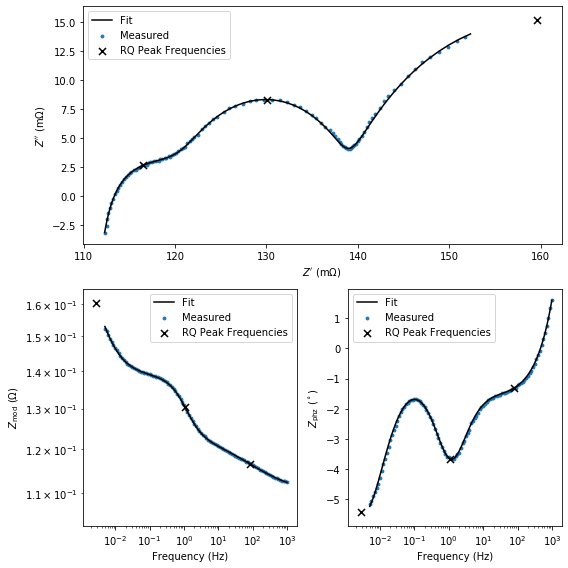

In [146]:
# fit equivalent circuit model to LIB data
tdf = gt.construct_eis_df(lib_df['Freq'],Z_lib)
lib_params, lib_hist = gt.fit_var_RC(tdf,0,1e-10,min_geo_gain=2,min_ari_gain=0.001,max_num_RC=3,
                                  early_stop=False,return_history=True,random_seed=11,
                                 frequency_bounds=(1e-6,1e3),simplex_params={'shift_factor':5})

# plot ECM fit
gt.plot_fit(tdf,lib_params,model=gt.Z_var_num_RC,mark_peaks=True)

In [29]:
tco_params = load_pickle('../data/experimental/EcmParams_PDAC-ger.pkl')
gt.sort_RQ(tco_params)

{'HFR': 8.128746803330995e-10,
 'Y': 6.939335089772127e-08,
 't0': 6.651074843720088,
 'R0': 3189882.240646773,
 'Q0': 2.276990900041586e-10,
 'n0': 0.9674552908941709,
 'R1': 903462.5947392369,
 'Q1': 1.0863687779944302e-08,
 'n1': 0.7985197995352473}

In [30]:
1/(tco_params['Y'])

14410602.55865001

In [200]:
# get analytical DRT from ECM
tau_lib = 1/(2*np.pi*np.logspace(4,-5,200))
g_lib = drt_from_ecm(lib_params,tau_lib)
Gres = pd.DataFrame(np.array([tau_lib,g_lib]).T,columns=['tau','gamma'])
# save DRT to file
Gres.to_csv('../data/experimental/gamma_LIB_ECM.csv',index=False)
# save ECM fit parameters
save_pickle(lib_params,'../data/experimental/EcmParams_LIB.pkl')
# save ECM impedance fit
Z_ecm = gt.Z_var_num_RC(lib_df['Freq'].values,**lib_params)
df_ecm = gt.construct_eis_df(lib_df['Freq'].values,Z_ecm)
df_ecm.to_csv('../data/experimental/Z_ECM_LIB.csv')

Dumped pickle to ../data/experimental/EcmParams_LIB.pkl


## Protonic ceramic microelectrode
This data was collected in a high-throughput measurement of a thin film microelectrode array.

Initial parameters: {'HFR': 0, 'Y': 8.333333333333334e-08, 't0': 5, 'R0': 4200000.0, 'Q0': 4.0370022891369415e-10, 'n0': 0.85}
Initial peak frequencies: [289.37262380344606]


INFO:numexpr.utils:NumExpr defaulting to 4 threads.


1 RC element(s): Best result 3.56e+09 achieved within 1 restarts
New RQ element: peak frequency 3.97e+01, params {'R1': 3237263.4604820437, 'Q1': 6.482679142032727e-09, 'n1': 0.7}
2 RC element(s): Best result 1.06e+09 achieved within 2 restarts
Could not achieve target objective function with 2 RC elements, but satisfied min_gain


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002246ECFD948>,
      dtype=object)

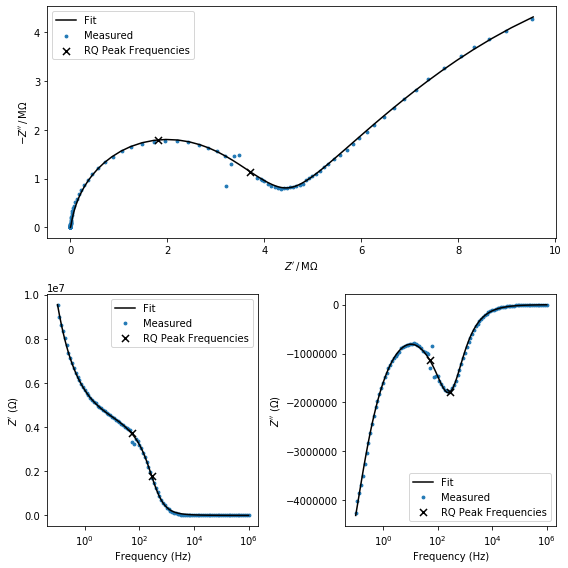

In [5]:
# file from: spectra_20200409\PDAC_COM3_02109_16pts_5x_R1_dryair_500C_2
tco_file = '../data/experimental/PDAC_COM3_02109_Contact10_2065C_500C.txt'
tco_df = gt.read_eis_zdata(tco_file)

# fit ECM with Gerischer and ZARCs to data
def Z_varRQ_ger(w,HFR,Y,t0,**RC_params):
    """
    Impedance of circuit with 1-n parallel RQ circuits in series with a resistor (HFR) and Gerischer element (Y, t0)
    Args:
        w: frequency (Hz)
        HFR: high-frequency resistance
        Y: admittance of Gerischer element
        t0: characteristic time constant of Gerischer element
        RC_params: parameters for each parallel RQ circuit. keys: R, Q, n
    """
    num_RC = int(len(RC_params)/3)

    Z_RC = [gt.Z_par(gt.Z_cpe(w,RC_params[f'Q{i}'],RC_params[f'n{i}']), RC_params[f'R{i}']) for i in range(num_RC)]

    return gt.Z_ger(w,Y,t0) + HFR + np.sum(Z_RC,axis=0)

# remove corrupted data points before fitting
cdf = tco_df[~tco_df.index.isin([61,62,63,64])]

# estimate initial parameters from DRT
init_params = {'R0':4.2e6,'Q0':0.55e-3**0.85/4.2e6,'n0':0.85,'Y':1/1.2e7,'t0':5,'HFR':0}

tcog_params,tcog_hist = gt.fit_var_RC(cdf,0,1e-10,min_geo_gain=2,min_ari_gain=0.001,max_num_RC=2,
                                    model = Z_varRQ_ger,init_params=init_params,est_HFR=False,
                                  early_stop=False,return_history=True,random_seed=11,weighting='unity',
                                 frequency_bounds=None,simplex_params={'shift_factor':5})
# plot ECM fit
gt.plot_fit(tco_df,tcog_params,model=Z_varRQ_ger,mark_peaks=True,bode_cols=['Zreal','Zimag'])

In [9]:
tco_df['Freq']

0      1.000020e+06
1      8.577539e+05
2      7.356445e+05
3      6.309961e+05
4      5.412305e+05
           ...     
101    1.848383e-01
102    1.587906e-01
103    1.359484e-01
104    1.167206e-01
105    1.001603e-01
Name: Freq, Length: 106, dtype: float64

Initial parameters: {'HFR': 1, 'R0': 1000000.0, 'Q0': 0.001, 'n0': 0.5}
Initial peak frequencies: [1.5915494309189535e-07]
1 RC element(s): Best result 6.99e+11 achieved within 1 restarts
New RQ element: peak frequency 4.64e+01, params {'R1': 3289140.6783565427, 'Q1': 5.722129937889218e-09, 'n1': 0.7}
2 RC element(s): Best result 2.95e+09 achieved within 3 restarts
New RQ element: peak frequency 1.36e-01, params {'R2': 12595042.547885155, 'Q2': 8.865690840229919e-08, 'n2': 0.7}
3 RC element(s): Best result 8.89e+08 achieved within 1 restarts
Could not achieve target objective function with 3 RC elements, but satisfied min_gain


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002246F7A0E88>,
      dtype=object)

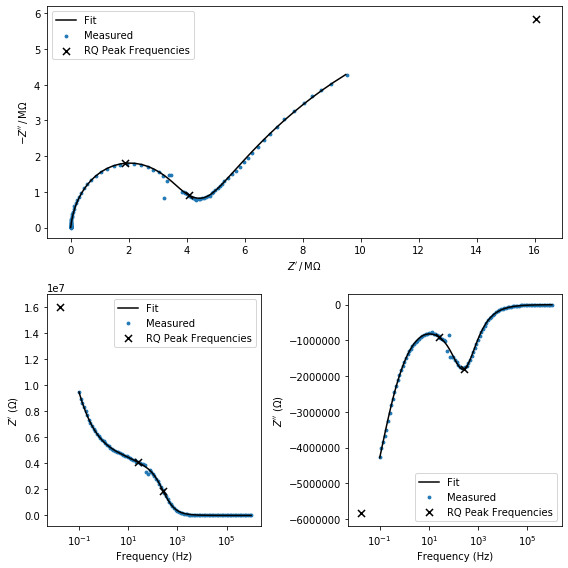

In [10]:
# fit ECM with only ZARCs to data
tco_params,tco_hist = gt.fit_var_RC(cdf,0,1e-10,min_geo_gain=2,min_ari_gain=0.001,max_num_RC=3,
                                    model=gt.Z_var_num_RC_noL,est_HFR=False,
                                  early_stop=False,return_history=True,random_seed=11,weighting='unity',
                                 frequency_bounds=None,simplex_params={'shift_factor':5})
# plot ECM fit
gt.plot_fit(tco_df,tco_params,model=gt.Z_var_num_RC_noL,mark_peaks=True,bode_cols=['Zreal','Zimag'])

In [7]:
tau_tco = 1/(2*np.pi*np.logspace(7,-3,200))
# get analytical DRT from ECM
# with Gerischer
g_tcog = drt_from_ecm(tcog_params,tau_tco,2)
g_tcog += (1/tcog_params['Y'])*ger_drt(tau_tco,tcog_params['t0'])
Gresg = pd.DataFrame(np.array([tau_tco,g_tcog]).T,columns=['tau','gamma'])
# without Gerischer
g_tco = drt_from_ecm(tco_params,tau_tco,3)
Gres = pd.DataFrame(np.array([tau_tco,g_tco]).T,columns=['tau','gamma'])
# save DRTs to files
Gresg.to_csv('../data/experimental/gamma_PDAC_ECM-ger.csv',index=False)
Gres.to_csv('../data/experimental/gamma_PDAC_ECM.csv',index=False)
# save ECM fit parameters
save_pickle(tcog_params,'../data/experimental/EcmParams_PDAC-ger.pkl')
save_pickle(tco_params,'../data/experimental/EcmParams_PDAC.pkl')
# save ECM impedance fit (with Gerischer)
Z_ecmg = Z_varRQ_ger(tco_df['Freq'].values,**tcog_params)
df_ecmg = gt.construct_eis_df(tco_df['Freq'].values,Z_ecmg)
df_ecmg.to_csv('../data/experimental/Z_ECM-ger_PDAC.csv')
# save ECM impedance fit (without Gerischer)
Z_ecm = gt.Z_var_num_RC_noL(tco_df['Freq'].values,**tco_params)
df_ecm = gt.construct_eis_df(tco_df['Freq'].values,Z_ecm)
df_ecm.to_csv('../data/experimental/Z_ECM_PDAC.csv')

Dumped pickle to ../data/experimental/EcmParams_PDAC-ger.pkl
Dumped pickle to ../data/experimental/EcmParams_PDAC.pkl


In [13]:
gt.sort_RQ(tco_params)

{'HFR': 6.178841029690012e-14,
 'R0': 3546204.294372742,
 'Q0': 2.58379565014462e-10,
 'n0': 0.9442181918711436,
 'R1': 831039.9697037678,
 'Q1': 2.668792536649725e-08,
 'n1': 0.7495870748610849,
 'R2': 23345469.146193173,
 'Q2': 1.581300237637885e-07,
 'n2': 0.5896458079983166}

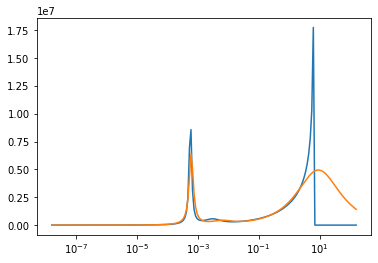

In [245]:
# g_tco = drt_from_ecm(tco_hist[1]['params'],tau_tco)
plt.plot(tau_tco,g_tcog)
plt.plot(tau_tco,g_tco)
plt.xscale('log')

Best result 1.04e+09 achieved within 2 restarts


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224719E3648>,
      dtype=object)

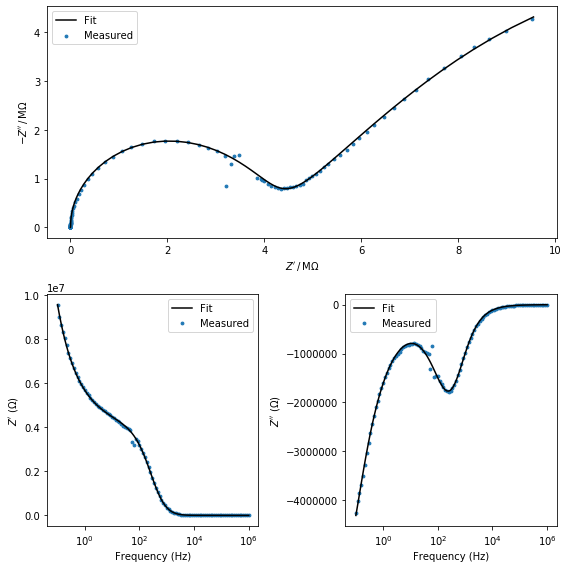

In [62]:
# fit ECM with Gerischer and HN element to data
def Z_G_HN(w,HFR,Rct,t0hn,nu,beta,Y,t0g):
    """
    Impedance of circuit with 1-n parallel RQ circuits in series with a resistor (HFR) and Gerischer element (y, t0)
    Args:
        w: frequency (Hz)
        HFR: high-frequency (ohmic) resistance
        Rct: resistance of HN element
        t0hn: time constant of HN element
        nu: nu parameter for HN element
        beta: beta parameter of HN element
        Y: admittance of Gerischer element
        t0g: time constant of Gerischer element
    """

    return gt.Z_HN(w,Rct,t0hn,nu,beta) + HFR + gt.Z_ger(w,Y,t0g)

# remove corrupted data points before fitting
cdf = tco_df[~tco_df.index.isin([61,62,63,64])]

# estimate initial parameters from DRT
init_params = {'HFR':0,'Rct':1e6,'t0hn':1e-3,'nu':0.5,'beta':0.5,'Y':1/1.2e7,'t0g':5}

tcogh_params = gt.fit_ec_model(cdf,model=Z_G_HN,init_params=init_params,est_HFR=False,
                                  random_seed=11,weighting='unity',simplex_params={'shift_factor':5})

# plot ECM fit
gt.plot_fit(tco_df,tcogh_params,model=Z_G_HN,bode_cols=['Zreal','Zimag'])

In [63]:
tau_tco = 1/(2*np.pi*np.logspace(7,-3,200))
# get analytical DRT from ECM with HN and Gerischer
g_tcogh = tcogh_params['Rct']*hn_drt(tau_tco,tcogh_params['t0hn'],tcogh_params['nu'],tcogh_params['beta'])
g_tcogh += (1/tcogh_params['Y'])*ger_drt(tau_tco,tcogh_params['t0g'])
Gresgh = pd.DataFrame(np.array([tau_tco,g_tcogh]).T,columns=['tau','gamma'])

# save DRT to file
Gresgh.to_csv('../data/experimental/gamma_PDAC_ECM-GHN.csv',index=False)
# save ECM fit parameters
save_pickle(tcogh_params,'../data/experimental/EcmParams_PDAC-GHN.pkl')
# save ECM impedance fit
Z_ecmgh = Z_G_HN(tco_df['Freq'].values,**tcogh_params)
df_ecmgh = gt.construct_eis_df(tco_df['Freq'].values,Z_ecmgh)
df_ecmgh.to_csv('../data/experimental/Z_ECM-GHN_PDAC.csv')

Dumped pickle to ../data/experimental/EcmParams_PDAC-GHN.pkl


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224721032C8>,
      dtype=object)

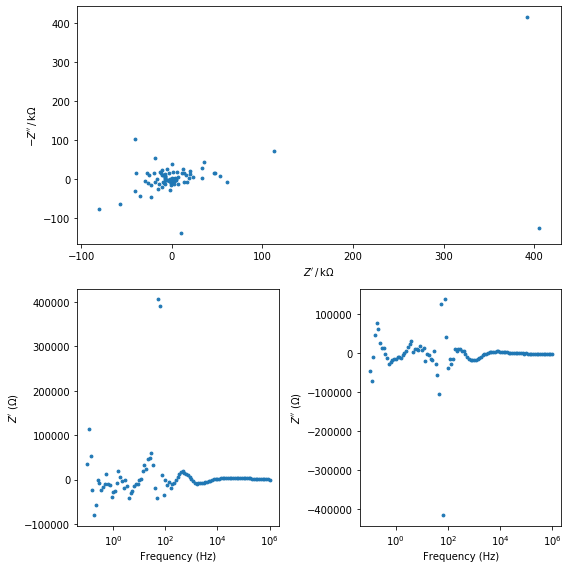

In [56]:
w = tco_df['Freq'].values
Z_pred = Z_G_HN(w,**tcogh_params)
err_df = tco_df.copy()
err_df['Zreal'] = Z_pred.real - tco_df['Zreal'].values
err_df['Zimag'] = Z_pred.imag - tco_df['Zimag'].values

gt.plot_full_eis(err_df,bode_cols=['Zreal','Zimag'])

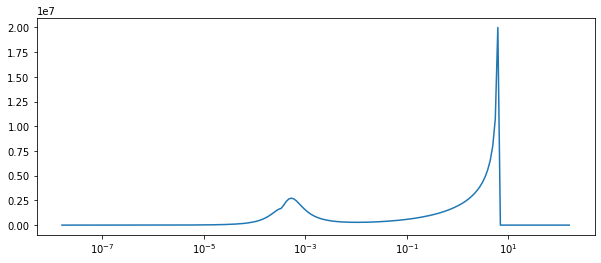

In [67]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(tau_tco,Gresgh['gamma'])
ax.set_xscale('log')

In [68]:
tcogh_params

{'HFR': 0.0004971475324541474,
 'Rct': 4086120.5233765305,
 't0hn': 0.0004462380890427157,
 'nu': 0.8003486336686649,
 'beta': 1.3877922195760375,
 'Y': 6.974978473645373e-08,
 't0g': 6.558840125870216}

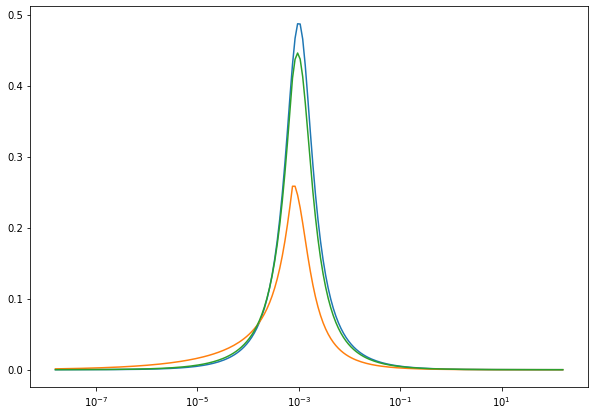

In [73]:
fig,ax = plt.subplots(figsize=(10,7))

tz = zarc_drt(tau_tco,1e-3,0.8)
th1 = hn_drt(tau_tco,1e-3,0.8,0.5)
th2 = hn_drt(tau_tco,1e-3,0.8,0.9)

ax.plot(tau_tco,tz)
ax.plot(tau_tco,th1)
ax.plot(tau_tco,th2)
ax.set_xscale('log')